### Part 1: Mapping Grocery Store Locations

To identify the locations of grocery stores, we are using data published by the USDA on the locations of authorized SNAP retailers. This data can be downloaded from https://www.fns.usda.gov/snap/retailer-locator. Additionally, it can be accessed directly by API. This is a particularly important use of APIs because the data is refreshed regularly.

In [1]:
# Import packages that will be useful for this assignment.
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

In [2]:
# Import data via API.
grocery_snap = gpd.read_file("https://services1.arcgis.com/RLQu0rK7h4kbsBq5/arcgis/rest/services/Store_Locations/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson")

# Look at basic data structure.
grocery_snap.head()

Store_Name                 Address Address_Line__2        City  \
0       CVS Pharmacy 9300      925 California Ave            None     Wahiawa   
1  KALAMA SHOPPING CENTER            223 N 1st St            None      Kalama   
2        Rebel Truck Stop  7349 Old Pacific Hwy S            None      Kalama   
3          Supermart #12       111 Bolstad Ave SE            None  Long Beach   
4        Pioneer Mart Llc      2006 Pacific Ave N            None  Long Beach   

  State   Zip5  Zip4    County  Longitude   Latitude  ObjectId  \
0    HI  96786  2123  HONOLULU -158.02536  21.497705         1   
1    WA  98625  None   COWLITZ -122.84501  46.008877         2   
2    WA  98625  9481   COWLITZ -122.82722  45.984581         3   
3    WA  98631  9202   PACIFIC -124.05382  46.351131         4   
4    WA  98631  3998   PACIFIC -124.05363  46.367340         5   

                      geometry  
0  POINT (-158.02536 21.49770)  
1  POINT (-122.84501 46.00888)  
2  POINT (-122.82722 45.98458)  
3  POINT (-124.05382 46.35113)  
4  POINT (-124.05363 46.36734)

This file contains data for the entire United States and we're only interested in the City of Los Angeles. We can solve by clipping this dataset to a LA Times neighborhoood boundary file that we'll use later anyways.<br><br> First I will import the neighborhood boundary data directly to a geodataframe.

In [3]:
neighborhoods = gpd.read_file("https://services5.arcgis.com/7nsPwEMP38bSkCjy/arcgis/rest/services/LA_Times_Neighborhoods/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson")

Now, I'll clip the SNAP retailers to the LA Times neighborhood boundary geodataframe to get just rows that are spatially within the boundaries of one of the neighborhoods of LA.

<AxesSubplot: >

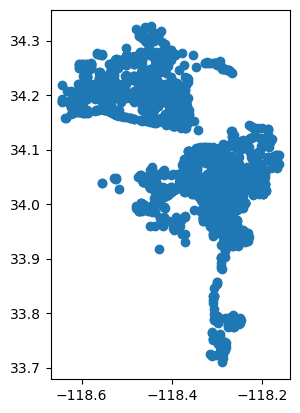

In [4]:
#Create a new geodataframe made up of the grocery store points, clipped to the "mask" of the neighborhood boundaries so that you're left with just grocery stores in City of LA.
snap_la = gpd.clip(grocery_snap, neighborhoods)

#Check to see if this worked.
snap_la.plot()

Good! We now just have locations within Los Angeles. However, we must solve an additional problem - many locations that do not provide access to healthy food (e.g. convenient stores, gas station markets, etc.) accept EBT.<br><br>Additionally, stores name's are generally unique to each location, which makes it difficult to analyze trends. To solve these problems, I am going to create some new columns that assign SNAP retailers to various categories based on their store name.

In [5]:
#Set the strings to be all lower case to minimize the number of variations on the same name that we have to search for.
snap_la['Store_Name']=snap_la['Store_Name'].str.lower()

/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [6]:
#Create snap_clean.
snap_clean = snap_la

In [7]:
#Define name of new variable.
snap_clean['location_type']='unknown'

#Label places that are unwanted chains.
snap_clean.loc[snap_clean['Store_Name'].str.contains("7-eleven"), 'location_type'] = 'Non-grocery chain'
snap_clean.loc[snap_clean['Store_Name'].str.contains("7 eleven"), 'location_type'] = 'Non-grocery chain'
snap_clean.loc[snap_clean['Store_Name'].str.contains("7eleven"), 'location_type'] = 'Non-grocery chain'
snap_clean.loc[snap_clean['Store_Name'].str.contains("store #63233"), 'location_type'] = 'Non-grocery chain'
snap_clean.loc[snap_clean['Store_Name'].str.contains("store #68540"), 'location_type'] = 'Non-grocery chain'
snap_clean.loc[snap_clean['Store_Name'].str.contains("big lots"), 'location_type'] = 'Non-grocery chain'

#Label places that are liquor stores. 
snap_clean.loc[snap_clean['Store_Name'].str.contains("liquor"), 'location_type'] = 'Liquor Store'
snap_clean.loc[snap_clean['Store_Name'].str.contains("wine"), 'location_type'] = 'Liquor Store'
snap_clean.loc[snap_clean['Store_Name'].str.contains("beer"), 'location_type'] = 'Liquor Store'

#Label places that are pharmacies. 
snap_clean.loc[snap_clean['Store_Name'].str.contains("cvs"), 'location_type'] = 'Pharmacy (e.g. CVS, Walgreens, Rite Aid)'
snap_clean.loc[snap_clean['Store_Name'].str.contains("rite aid"), 'location_type'] = 'Pharmacy (e.g. CVS, Walgreens, Rite Aid)'
snap_clean.loc[snap_clean['Store_Name'].str.contains("walgreens"), 'location_type'] = 'Pharmacy (e.g. CVS, Walgreens, Rite Aid)'

#Label places that are small gas station marts.
snap_clean.loc[snap_clean['Store_Name'].str.contains("chevron"), 'location_type'] = 'Gas station (e.g. Chevron, Circle K, G&M Oil)'
snap_clean.loc[snap_clean['Store_Name'].str.contains("circle k"), 'location_type'] = 'Gas station (e.g. Chevron, Circle K, G&M Oil)'
snap_clean.loc[snap_clean['Store_Name'].str.contains("g&m"), 'location_type'] = 'Gas station (e.g. Chevron, Circle K, G&M Oil)'
snap_clean.loc[snap_clean['Store_Name'].str.contains("arco"), 'location_type'] = 'Gas station (e.g. Chevron, Circle K, G&M Oil)'
snap_clean.loc[snap_clean['Store_Name'].str.contains("rocket"), 'location_type'] = 'Gas station (e.g. Chevron, Circle K, G&M Oil)'
snap_clean.loc[snap_clean['Store_Name'].str.contains("speedway"), 'location_type'] = 'Gas station (e.g. Chevron, Circle K, G&M Oil)'
snap_clean.loc[snap_clean['Store_Name'].str.contains("united pacific"), 'location_type'] = 'Gas station (e.g. Chevron, Circle K, G&M Oil)'
snap_clean.loc[snap_clean['Store_Name'].str.contains("store #68539"), 'location_type'] = 'Gas station (e.g. Chevron, Circle K, G&M Oil)'
snap_clean.loc[snap_clean['Store_Name'] == "arcoiris 98 cents store", 'location_type'] = 'unknown'
snap_clean.loc[snap_clean['Store_Name'] == "larco37", 'chain_name'] = 'location_type'
snap_clean.loc[snap_clean['Store_Name'] == "tortilleria san marcos", 'location_type'] = 'unknown'
snap_clean.loc[snap_clean['Store_Name'].str.contains("h & s energy products"), 'location_type'] = 'Gas station (e.g. Chevron, Circle K, G&M Oil)'

#Label places that are dollar stores.
snap_clean.loc[snap_clean['Store_Name'].str.contains("99 cents only"), 'location_type'] = 'Dollar store (e.g. 99 Cents Only, Dollar Tree)'
snap_clean.loc[snap_clean['Store_Name'].str.contains("99 cent only"), 'location_type'] = 'Dollar store (e.g. 99 Cents Only, Dollar Tree)'
snap_clean.loc[snap_clean['Store_Name'].str.contains("dollar tree"), 'location_type'] = 'Dollar store (e.g. 99 Cents Only, Dollar Tree)'
snap_clean.loc[snap_clean['Store_Name'].str.contains("family dollar"), 'location_type'] = 'Dollar store (e.g. 99 Cents Only, Dollar Tree)'

#See how things are looking.
snap_clean.head()

/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Store_Name             Address Address_Line__2       City  \
162264               vons 2162      1440 W 25th St            None  San Pedro   
207329       smart & final 923      1636 W 25th St            None  San Pedro   
55762              alma market      2305 S Alma St            None  San Pedro   
162571       south shore water  2434 S Western Ave            None  San Pedro   
161699  7 eleven store 18668 c      1700 W 25th St            None  San Pedro   

       State   Zip5  Zip4       County  Longitude   Latitude  ObjectId  \
162264    CA  90732  4418  LOS ANGELES -118.31068  33.721760    162265   
207329    CA  90732  4302  LOS ANGELES -118.31312  33.723164    207330   
55762     CA  90731  5714  LOS ANGELES -118.29908  33.723179     55763   
162571    CA  90732  4334  LOS ANGELES -118.31236  33.723270    162572   
161699    CA  90732  4201  LOS ANGELES -118.31499  33.724384    161700   

                           geometry      location_type chain_name  
162264  POINT (-118.31068 33.72176)            unknown        NaN  
207329  POINT (-118.31312 33.72316)            unknown        NaN  
55762   POINT (-118.29908 33.72318)            unknown        NaN  
162571  POINT (-118.31236 33.72327)            unknown        NaN  
161699  POINT (-118.31499 33.72438)  Non-grocery chain        NaN

In part because it willl be difficult to create a fully "clean" dataset based on exclusions, I'm also interested in the locations of chain grocery stores.<br><br>
To begin this analysis, I'll create a new column with the name of the chain that a grocery store is a member of if the name matches a substring search. Not that this is similarly not comprehensive.

In [8]:
#Define name of new variable.
snap_clean['chain_name']='unknown'

#Set a new value for chain_name if Store_Name contains a specified substring. Note that this list is not exhaustive and will be added to throughout the project. 
snap_clean.loc[snap_clean['Store_Name'].str.contains('albertsons'), 'chain_name'] = 'Albertsons'
snap_clean.loc[snap_clean['Store_Name'].str.contains("albertson's"), 'chain_name'] = 'Albertsons'
snap_clean.loc[snap_clean['Store_Name'].str.contains("aldi"), 'chain_name'] = 'Aldi'
snap_clean.loc[snap_clean['Store_Name'].str.contains("amazon"), 'chain_name'] = 'Amazon Fresh'
snap_clean.loc[snap_clean['Store_Name'] == "amazon go (bowser) ils2", 'chain_name'] = "unknown"
snap_clean.loc[snap_clean['Store_Name'].str.contains("bristol farms"), 'chain_name'] = 'Bristol Farms'
snap_clean.loc[snap_clean['Store_Name'].str.contains("costco"), 'chain_name'] = 'Costco'
snap_clean.loc[snap_clean['Store_Name'].str.contains("garibaldi"), 'chain_name'] = 'unknown'
snap_clean.loc[snap_clean['Store_Name'].str.contains('el super'), 'chain_name'] = 'El Super'
snap_clean.loc[snap_clean['Store_Name'].str.contains('food 4 less'), 'chain_name'] = 'Food 4 Less'
snap_clean.loc[snap_clean['Store_Name'].str.contains("food for less"), 'chain_name'] = 'Food 4 Less'
snap_clean.loc[snap_clean['Store_Name'].str.contains("gelson's market"), 'chain_name'] = "Gelson's"
snap_clean.loc[snap_clean['Store_Name'].str.contains("gelsons market"), 'chain_name'] = "Gelson's"
snap_clean.loc[snap_clean['Store_Name'].str.contains("h mart"), 'chain_name'] = "H Mart"
snap_clean.loc[snap_clean['Store_Name'] == "bh mart", 'chain_name'] = "unknown"
snap_clean.loc[snap_clean['Store_Name'] == "venice beach mart", 'chain_name'] = "unknown"
snap_clean.loc[snap_clean['Store_Name'].str.contains("jons market"), 'chain_name'] = "JONS"
snap_clean.loc[snap_clean['Store_Name'].str.contains("mother's nutritional center"), 'chain_name'] = "Mother's Nutritional Center"
snap_clean.loc[snap_clean['Store_Name'].str.contains("northgate market"), 'chain_name'] = "Northgate Market"
snap_clean.loc[snap_clean['Store_Name'].str.contains("numero uno market"), 'chain_name'] = "Numero Uno Market"
snap_clean.loc[snap_clean['Store_Name'].str.contains("ralphs"), 'chain_name'] = 'Ralphs'
snap_clean.loc[snap_clean['Store_Name'].str.contains("ralph's"), 'chain_name'] = 'Ralphs'
snap_clean.loc[snap_clean['Store_Name'].str.contains("pavilions"), 'chain_name'] = 'Pavilions'
snap_clean.loc[snap_clean['Store_Name'].str.contains("seafood city supermarket"), 'chain_name'] = 'Seafood City Supermarket'
snap_clean.loc[snap_clean['Store_Name'].str.contains("smart & final"), 'chain_name'] = 'Smart & Final'
snap_clean.loc[snap_clean['Store_Name'].str.contains("smart and final"), 'chain_name'] = 'Smart & Final'
snap_clean.loc[snap_clean['Store_Name'].str.contains("sprouts"), 'chain_name'] = 'Sprouts'
snap_clean.loc[snap_clean['Store_Name'].str.contains("superior grocers"), 'chain_name'] = 'Superior Grocers'
snap_clean.loc[snap_clean['Store_Name'].str.contains("super king market"), 'chain_name'] = 'Super King Market'
snap_clean.loc[snap_clean['Store_Name'].str.contains("target"), 'chain_name'] = "Target"
snap_clean.loc[snap_clean['Store_Name'].str.contains("trader joe's"), 'chain_name'] = "Trader Joe's"
snap_clean.loc[snap_clean['Store_Name'].str.contains("trader joes"), 'chain_name'] = "Trader Joe's"
snap_clean.loc[snap_clean['Store_Name'].str.contains("vallarta supermarket"), 'chain_name'] = 'Vallarta Spermarkets'
snap_clean.loc[snap_clean['Store_Name'].str.contains("supermercado vallarta"), 'chain_name'] = 'Vallarta Spermarkets'
snap_clean.loc[snap_clean['Store_Name'].str.contains("vons"), 'chain_name'] = 'Vons'
snap_clean.loc[snap_clean['Store_Name'].str.contains("walmart"), 'chain_name'] = 'Walmart'
snap_clean.loc[snap_clean['Store_Name'].str.contains("whole foods"), 'chain_name'] = 'Whole Foods'
snap_clean.head()

# Label all of these designtaed supermarket chains in the location_type column.
snap_clean.loc[snap_clean['chain_name'] != 'unknown', 'location_type'] = 'Supermarket Chain'

/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [9]:
snap_clean['chain_type']='unknown'
# Standard chain. 
snap_clean.loc[snap_clean['chain_name'] == "Ralphs", 'chain_type'] = "Standard chain (e.g. Ralphs, Trader Joe's)"
snap_clean.loc[snap_clean['chain_name'] == "Trader Joe's", 'chain_type'] = "Standard chain (e.g. Ralphs, Trader Joe's)"
snap_clean.loc[snap_clean['chain_name'] == "Vons", 'chain_type'] = "Standard chain (e.g. Ralphs, Trader Joe's)"
snap_clean.loc[snap_clean['chain_name'] == "Numero Uno Market", 'chain_type'] = "Standard chain (e.g. Ralphs, Trader Joe's)"
snap_clean.loc[snap_clean['chain_name'] == "JONS", 'chain_type'] = "Standard chain (e.g. Ralphs, Trader Joe's)"
snap_clean.loc[snap_clean['chain_name'] == "El Super", 'chain_type'] = "Standard chain (e.g. Ralphs, Trader Joe's)"
snap_clean.loc[snap_clean['chain_name'] == "Albertsons", 'chain_type'] = "Standard chain (e.g. Ralphs, Trader Joe's)"
snap_clean.loc[snap_clean['chain_name'] == "Amazon Fresh", 'chain_type'] = "Standard chain (e.g. Ralphs, Trader Joe's)"
snap_clean.loc[snap_clean['chain_name'] == "Pavilions", 'chain_type'] = "Standard chain (e.g. Ralphs, Trader Joe's)"
snap_clean.loc[snap_clean['chain_name'] == "Super King Market", 'chain_type'] = "Standard chain (e.g. Ralphs, Trader Joe's)"
snap_clean.loc[snap_clean['chain_name'] == "Aldi", 'chain_type'] = "Standard chain (e.g. Ralphs, Trader Joe's)"
snap_clean.loc[snap_clean['chain_name'] == "Vallarta Spermarkets", 'chain_type'] = "Standard chain (e.g. Ralphs, Trader Joe's)"
snap_clean.loc[snap_clean['chain_name'] == "Superior Grocers", 'chain_type'] = "Standard chain (e.g. Ralphs, Trader Joe's)"
snap_clean.loc[snap_clean['chain_name'] == "Northgate Market", 'chain_type'] = "Standard chain (e.g. Ralphs, Trader Joe's)"
snap_clean.loc[snap_clean['chain_name'] == "Seafood City Supermarket", 'chain_type'] = "Standard chain (e.g. Ralphs, Trader Joe's)"
snap_clean.loc[snap_clean['chain_name'] == "H Mart", 'chain_type'] = "Standard chain (e.g. Ralphs, Trader Joe's)"
# Description uses words 'bulk,' 'discount,' or 'vouchers'
snap_clean.loc[snap_clean['chain_name'] == "Smart & Final", 'chain_type'] = "Discount (e.g. Smart & Final, Food 4 Less)"
snap_clean.loc[snap_clean['chain_name'] == "Food 4 Less", 'chain_type'] = "Discount (e.g. Smart & Final, Food 4 Less)"
snap_clean.loc[snap_clean['chain_name'] == "Mother's Nutritional Center", 'chain_type'] = "Discount (e.g. Smart & Final, Food 4 Less)"
snap_clean.loc[snap_clean['chain_name'] == "Costco", 'chain_type'] = "Discount (e.g. Smart & Final, Food 4 Less)"
# Description uses words 'organic' or 'gourmet'
snap_clean.loc[snap_clean['chain_name'] == "Whole Foods", 'chain_type'] = "Upscale (e.g. Whole Foods, Sprouts)"
snap_clean.loc[snap_clean['chain_name'] == "Gelson's", 'chain_type'] = "Upscale (e.g. Whole Foods, Sprouts)"
snap_clean.loc[snap_clean['chain_name'] == "Sprouts", 'chain_type'] = "Upscale (e.g. Whole Foods, Sprouts)"
snap_clean.loc[snap_clean['chain_name'] == "Bristol Farms", 'chain_type'] = "Upscale (e.g. Whole Foods, Sprouts)"
# Department stores. 
snap_clean.loc[snap_clean['chain_name'] == "Target", 'chain_type'] = "Department store (e.g. Target, Walmart)"
snap_clean.loc[snap_clean['chain_name'] == "Walmart", 'chain_type'] = "Department store (e.g. Target, Walmart)"

/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Now, I will create two new "clean" geodataframes: one that remove the stores tagged as non-grocery stores and on that has just the grocery stores that have been assigned to a known chain.

In [10]:
# Create a version that has all rows not identified as non-grocery stores. 
retailers_clean = snap_clean.loc[snap_clean['location_type']!='Non-grocery chain'].copy()
retailers_clean = retailers_clean.loc[retailers_clean['location_type']!='Liquor Store']
retailers_clean = retailers_clean.loc[retailers_clean['location_type']!='Pharmacy (e.g. CVS, Walgreens, Rite Aid)']
retailers_clean = retailers_clean.loc[retailers_clean['location_type']!='Gas station (e.g. Chevron, Circle K, G&M Oil)']
retailers_clean = retailers_clean.loc[retailers_clean['location_type']!='Dollar store (e.g. 99 Cents Only, Dollar Tree)']
retailers_clean.head()

Store_Name             Address Address_Line__2  \
162264                          vons 2162      1440 W 25th St            None   
207329                  smart & final 923      1636 W 25th St            None   
55762                         alma market      2305 S Alma St            None   
162571                  south shore water  2434 S Western Ave            None   
89108   numero uno market - san pedro 121        970 W 1st St            None   

             City State   Zip5  Zip4       County  Longitude   Latitude  \
162264  San Pedro    CA  90732  4418  LOS ANGELES -118.31068  33.721760   
207329  San Pedro    CA  90732  4302  LOS ANGELES -118.31312  33.723164   
55762   San Pedro    CA  90731  5714  LOS ANGELES -118.29908  33.723179   
162571  San Pedro    CA  90732  4334  LOS ANGELES -118.31236  33.723270   
89108   San Pedro    CA  90731  1998  LOS ANGELES -118.29841  33.743370   

        ObjectId                     geometry      location_type  \
162264    162265  POINT (-118.31068 33.72176)  Supermarket Chain   
207329    207330  POINT (-118.31312 33.72316)  Supermarket Chain   
55762      55763  POINT (-118.29908 33.72318)            unknown   
162571    162572  POINT (-118.31236 33.72327)            unknown   
89108      89109  POINT (-118.29841 33.74337)  Supermarket Chain   

               chain_name                                  chain_type  
162264               Vons  Standard chain (e.g. Ralphs, Trader Joe's)  
207329      Smart & Final  Discount (e.g. Smart & Final, Food 4 Less)  
55762             unknown                                     unknown  
162571            unknown                                     unknown  
89108   Numero Uno Market  Standard chain (e.g. Ralphs, Trader Joe's)

In [11]:
#Create new geodataframe that contains all rows assigned to a known supermarket chain.
grocery_chains = snap_clean.loc[snap_clean['chain_name']!='unknown'].copy()
grocery_chains.head()

Store_Name            Address Address_Line__2  \
162264                          vons 2162     1440 W 25th St            None   
207329                  smart & final 923     1636 W 25th St            None   
89108   numero uno market - san pedro 121       970 W 1st St            None   
175448         sprouts farmers market 252  820 N Western Ave            None   
49039                           vons 2283   1221 S Gaffey St            None   

             City State   Zip5  Zip4       County  Longitude   Latitude  \
162264  San Pedro    CA  90732  4418  LOS ANGELES -118.31068  33.721760   
207329  San Pedro    CA  90732  4302  LOS ANGELES -118.31312  33.723164   
89108   San Pedro    CA  90731  1998  LOS ANGELES -118.29841  33.743370   
175448  San Pedro    CA  90732  2426  LOS ANGELES -118.30910  33.750385   
49039   San Pedro    CA  90731  4014  LOS ANGELES -118.29240  33.732872   

        ObjectId                     geometry      location_type  \
162264    162265  POINT (-118.31068 33.72176)  Supermarket Chain   
207329    207330  POINT (-118.31312 33.72316)  Supermarket Chain   
89108      89109  POINT (-118.29841 33.74337)  Supermarket Chain   
175448    175449  POINT (-118.30910 33.75039)  Supermarket Chain   
49039      49040  POINT (-118.29240 33.73287)  Supermarket Chain   

               chain_name                                  chain_type  
162264               Vons  Standard chain (e.g. Ralphs, Trader Joe's)  
207329      Smart & Final  Discount (e.g. Smart & Final, Food 4 Less)  
89108   Numero Uno Market  Standard chain (e.g. Ralphs, Trader Joe's)  
175448            Sprouts         Upscale (e.g. Whole Foods, Sprouts)  
49039                Vons  Standard chain (e.g. Ralphs, Trader Joe's)

Now I will join the information about which neighborhood each chain supermarket is located within so that I can conduct some analysis about how grocery stores are distributed across neighborhoods.

In [12]:
# Add information about the neighborhood to the  geodataframe of locations that I have labeled as chain grocery store chains.
chain_with_neighborhood = gpd.sjoin(grocery_chains, neighborhoods) 

In [13]:
# Rename neighborhood columns so they make sense in context.
chain_with_neighborhood.rename(columns = {'name':'neighborhood_name', 'OBJECTID' : 'neighborhood_number'}, inplace = True)

# Drop index from neighborhood column which is unneccessary. 
chain_with_neighborhood=chain_with_neighborhood.drop(columns = ['index_right'])

In [14]:
chain_with_neighborhood.head()

Store_Name            Address Address_Line__2  \
162264                          vons 2162     1440 W 25th St            None   
207329                  smart & final 923     1636 W 25th St            None   
89108   numero uno market - san pedro 121       970 W 1st St            None   
175448         sprouts farmers market 252  820 N Western Ave            None   
49039                           vons 2283   1221 S Gaffey St            None   

             City State   Zip5  Zip4       County  Longitude   Latitude  \
162264  San Pedro    CA  90732  4418  LOS ANGELES -118.31068  33.721760   
207329  San Pedro    CA  90732  4302  LOS ANGELES -118.31312  33.723164   
89108   San Pedro    CA  90731  1998  LOS ANGELES -118.29841  33.743370   
175448  San Pedro    CA  90732  2426  LOS ANGELES -118.30910  33.750385   
49039   San Pedro    CA  90731  4014  LOS ANGELES -118.29240  33.732872   

        ObjectId                     geometry      location_type  \
162264    162265  POINT (-118.31068 33.72176)  Supermarket Chain   
207329    207330  POINT (-118.31312 33.72316)  Supermarket Chain   
89108      89109  POINT (-118.29841 33.74337)  Supermarket Chain   
175448    175449  POINT (-118.30910 33.75039)  Supermarket Chain   
49039      49040  POINT (-118.29240 33.73287)  Supermarket Chain   

               chain_name                                  chain_type  \
162264               Vons  Standard chain (e.g. Ralphs, Trader Joe's)   
207329      Smart & Final  Discount (e.g. Smart & Final, Food 4 Less)   
89108   Numero Uno Market  Standard chain (e.g. Ralphs, Trader Joe's)   
175448            Sprouts         Upscale (e.g. Whole Foods, Sprouts)   
49039                Vons  Standard chain (e.g. Ralphs, Trader Joe's)   

        neighborhood_number neighborhood_name  
162264                   80         San Pedro  
207329                   80         San Pedro  
89108                    80         San Pedro  
175448                   80         San Pedro  
49039                    80         San Pedro

I am curious what the most common chain grocery stores in the City of LA are, so I'll calculate a count of each chain.<br>The result of this calculation is that we learn Ralphs is the most prevalent chain with 43 locations in the City of LA.

In [15]:
chains_counts = chain_with_neighborhood.value_counts(['chain_name']).reset_index(name='count')
chains_counts

chain_name  count
0                        Ralphs     43
1                 Smart & Final     31
2                        Target     30
3                  Trader Joe's     22
4                   Food 4 Less     21
5                          Vons     20
6   Mother's Nutritional Center     19
7                   Whole Foods     15
8          Vallarta Spermarkets     13
9             Numero Uno Market     11
10                     Gelson's      9
11                         JONS      9
12                      Sprouts      9
13                     El Super      8
14             Superior Grocers      8
15                       Costco      7
16                   Albertsons      6
17             Northgate Market      5
18                 Amazon Fresh      5
19                      Walmart      5
20     Seafood City Supermarket      4
21                Bristol Farms      4
22                    Pavilions      4
23            Super King Market      3
24                         Aldi      3
25                       H Mart      3

That is too many chains to map, so I will create a new dataframe for the primary purpose of mapping. This new dataframe will contain a column (chain_map) that contains the chain's name for very big chains, and the chain type for smaller chains.

In [16]:
#Create new geodataframe for map.
chain_map=chain_with_neighborhood

# Create new variable that defaults to the chain type.
chain_map['chain_map'] = chain_map['chain_type']

# Replace value with the chain's name for Top 5 Chains.
chain_map.loc[chain_map['chain_name'] == "Ralphs", 'chain_map'] = "Ralphs"
chain_map.loc[chain_map['chain_name'] == "Smart & Final", 'chain_map'] = "Smart & Final"
chain_map.loc[chain_map['chain_name'] == "Target", 'chain_map'] = "Target"
chain_map.loc[chain_map['chain_name'] == "Trader Joe's", 'chain_map'] = "Trader Joe's"
chain_map.loc[chain_map['chain_name'] == "Food 4 Less", 'chain_map'] = "Food 4 Less"

# See how man there are in each category.
chainmap_counts = chain_map.value_counts(['chain_map']).reset_index(name='count')
chainmap_counts

chain_map  count
0  Standard chain (e.g. Ralphs, Trader Joe's)    102
1                                      Ralphs     43
2         Upscale (e.g. Whole Foods, Sprouts)     37
3                               Smart & Final     31
4                                      Target     30
5  Discount (e.g. Smart & Final, Food 4 Less)     26
6                                Trader Joe's     22
7                                 Food 4 Less     21
8     Department store (e.g. Target, Walmart)      5

I notice that by pulling the Targets out separately, there aren't enough department stores to map, so I'll fold these into standard chains.

In [17]:
chain_map.loc[chain_map['chain_name'] == "Walmart", 'chain_map'] = "Standard chain (e.g. Ralphs, Trader Joe's)"

Finally, I must rename my categories to remove references to chains that have been pulled out.

In [18]:
chain_map.loc[chain_map['chain_map'] == "Standard chain (e.g. Ralphs, Trader Joe's)", 'chain_map'] = "Other Standard Chain (e.g. Vons)"
chain_map.loc[chain_map['chain_map'] == "Discount (e.g. Smart & Final, Food 4 Less)", 'chain_map'] = "Other Discount Chain (e.g. Mother's Nutritional Center)"
chain_map.loc[chain_map['chain_map'] == "Upscale (e.g. Whole Foods, Sprouts)", 'chain_map'] = "Upscale Chain (e.g. Whole Foods)"

# See how man there are in each category.
chainmap_counts = chain_with_neighborhood.value_counts(['chain_map']).reset_index(name='count')
chainmap_counts

chain_map  count
0                   Other Standard Chain (e.g. Vons)    107
1                                             Ralphs     43
2                   Upscale Chain (e.g. Whole Foods)     37
3                                      Smart & Final     31
4                                             Target     30
5  Other Discount Chain (e.g. Mother's Nutritiona...     26
6                                       Trader Joe's     22
7                                        Food 4 Less     21

Finally, I want to reorder my dataframe so that they show up in my desired order in the map legend (first the top 5 chains in descending order of prevalence and then the chain groups)

In [19]:
# Create an order column with the desired order.
chain_map.loc[chain_map['chain_map'] == "Ralphs", 'chain_map_order'] = 1
chain_map.loc[chain_map['chain_map'] == "Smart & Final", 'chain_map_order'] = 2
chain_map.loc[chain_map['chain_map'] == "Target", 'chain_map_order'] = 3
chain_map.loc[chain_map['chain_map'] == "Trader Joe's", 'chain_map_order'] = 4
chain_map.loc[chain_map['chain_map'] == "Food 4 Less", 'chain_map_order'] = 5
chain_map.loc[chain_map['chain_map'] == "Other Standard Chain (e.g. Vons)", 'chain_map_order'] = 6
chain_map.loc[chain_map['chain_map'] == "Other Discount Chain (e.g. Mother's Nutritional Center)", 'chain_map_order'] = 7
chain_map.loc[chain_map['chain_map'] == "Upscale Chain (e.g. Whole Foods)", 'chain_map_order'] = 8

# Sort by my new order column.
chain_map=chain_map.sort_values('chain_map_order')

Now I can create some vizualizations to demonstrate the geographic locations of the grocery chains. 
1) An interactive stacked bar chart of grocery chains by neighborhood
2) Interactive maps of grocery chain locations

First, I will create a stacked bar chart that lets you explore how many grocery chains (and which grocery chains) are present in each neighborhood.

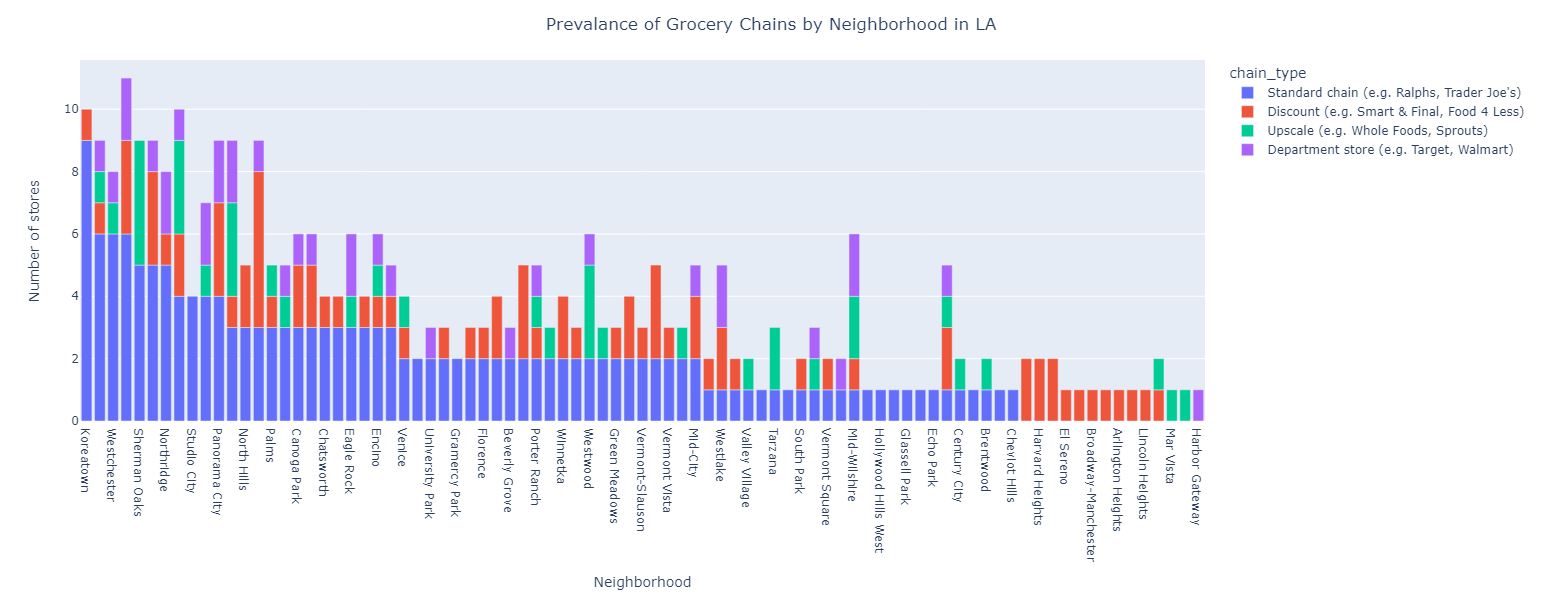

In [20]:
#Import required package.
import plotly.express as px

# Create a new dataframe that aggregates the data by neighborhood and chain name.
chains_grouped = chain_with_neighborhood.value_counts(['chain_type','neighborhood_name']).reset_index(name='count')
chains_grouped

# Make a stacked bar chart that is properly labeled and big enough for all labels to show up.
fig = px.bar(chains_grouped,
       x='neighborhood_name',
       y='count',
       color='chain_type',
       labels={
            'neighborhood_name':'Neighborhood',
            'count':'Number of stores'
        }
)

fig.update_layout(
    width = 1400,
    height = 600,
    title='Prevalance of Grocery Chains by Neighborhood in LA',
    title_x=0.5 # aligns title to center
)

fig.show()

Next, I will create an interactive map that has the locations of each grocery chain in the City of LA, where the markers are colored by the name of the chain. This helps us understand the spatial distribution of chains overall and _which_ chains are in which areas. For example, while Ralphs is the largest chain in the city, they have no real presence east of Downtown.

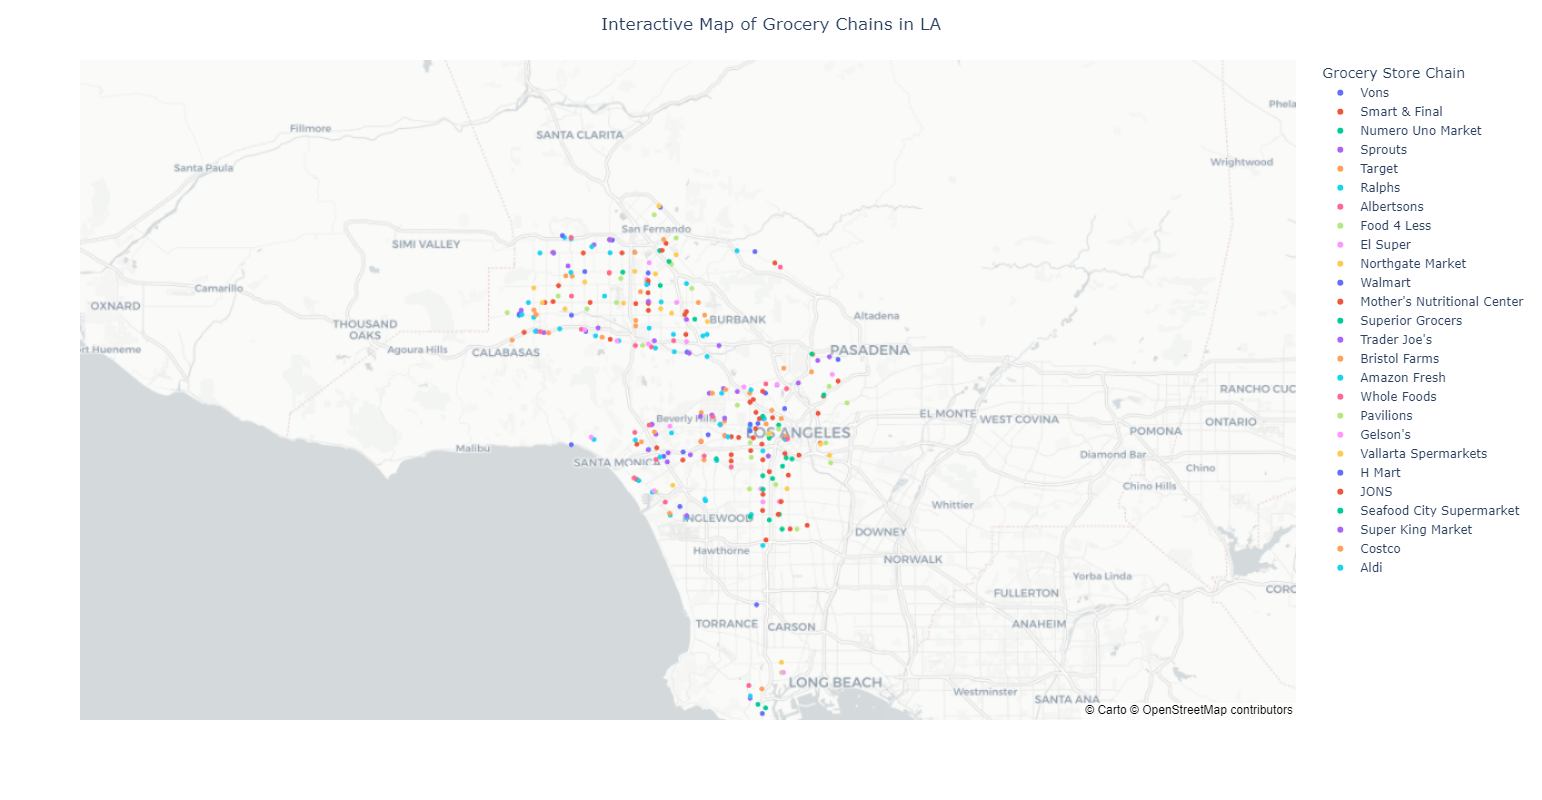

In [21]:
# Create an interactive map where markers are colored by the name of the chain.
fig = px.scatter_mapbox(chain_with_neighborhood,
                        lat='Latitude',
                        lon='Longitude',
                        color='chain_name',
                        mapbox_style="carto-positron",
                        labels={
                            'chain_name':'Grocery Store Chain',
                        })

# Update layout with desired size, zoom, title, etc.
fig.update_layout(
    width = 800,
    height = 800,
    mapbox_style="carto-positron",
    mapbox_zoom=9,
    title = "Interactive Map of Grocery Chains in LA",
    title_x=0.5 
)

fig.show()

This map has too many chains to be easy to process, so I'll map my chain_map version.

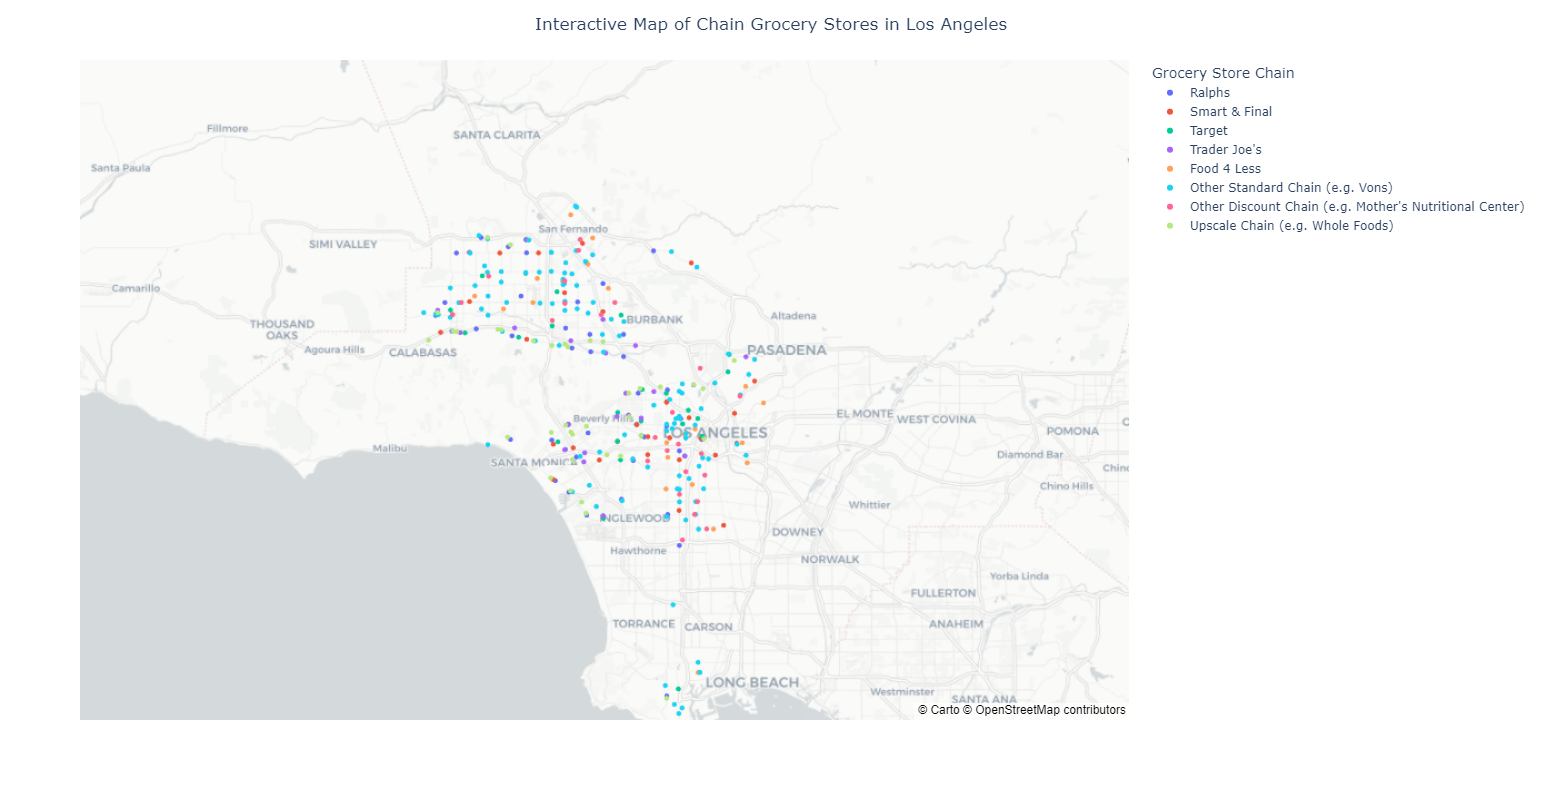

In [22]:
# Create an interactive map where markers are colored by the name of the chain.
fig = px.scatter_mapbox(chain_map,
                        lat='Latitude',
                        lon='Longitude',
                        color='chain_map',
                        mapbox_style="carto-positron",
                        labels={
                            'chain_map':'Grocery Store Chain',
                        })

# Update layout with desired size, zoom, title, etc.
# Chart specifically must be wider to accomodate the longer names in the legend.
fig.update_layout(
    width = 950,
    height = 800,
    mapbox_style="carto-positron",
    mapbox_zoom=9,
    title = "Interactive Map of Chain Grocery Stores in Los Angeles",
    title_x=0.5)

fig.show()

# Save this map for Midterm presentation.
fig.write_html('chain_map.html')

### Part 2: Identifying Block Groups with Walking Access to Grocery Stores
Now we're going to relate these locations to block groups and demographis! First I will read in a geojson file of the number of seniors per square mile for each block group in the City of LA.

To identify which block groups are within walking distance of a grocery store, I will:
1) Create various walking distance buffers around my grocery stores
2) Determine which census blocks are within these bbuffers. Ideally, I'd do proportional allocation calculations. However, for the Midterm, I will experiment with two ways of approximating the census blocks with access. First, I'll identify which block groups touch these buffers (which stringly overestimates access). Next, I'll identify which block groups have centroids within these buffers.

Since my walking distance calculations will be based in meters, I'll first have to convert the CRS of all geodataframes to EPSG 6423, which is the meter-based CRS for Los Angeles County. 

In [23]:
# Create a new geodataframe of chain locations that is in a projection that accurately calculates things in meters.
chains_projection=chain_with_neighborhood.to_crs('epsg:6423')

# Read the geojson file that Lucy created this week to get data on census block group demographics.
seniors=gpd.read_file('Percent_Senior_Basemap.geojson')

# Create a new geodataframe of blok groups that is in a projection that accurately calculates things in meters.
seniors_projection=seniors.to_crs('epsg:6423')

Now, I create two walking distance buffers around my grocery stores: 1/4 mile and 1/2 mile.

In [24]:
# Create a new geodataframe that will contain my 1/4 mile buffers. 
chains_buffer_025=chains_projection

# Add a new column (walkshed) that contains a 402.336 meter (1/4 mile) buffer around each point. 
chains_buffer_025['walkshed'] = chains_buffer_025.buffer(402.336)

# Make my new buffer column the primary geometry for the geodataframe. 
chains_buffer_025=chains_buffer_025.set_geometry('walkshed')

In [25]:
# Create a new geodataframe that will contain my 1/2 mile buffers. 
chains_buffer_050=chains_projection

# Add a new column (walkshed) that contains a 804.672 meter (1/2 mile) buffer around each point. 
chains_buffer_050['walkshed'] = chains_buffer_050.buffer(804.672)

# Make my new buffer column the primary geometry for the geodataframe. 
chains_buffer_050=chains_buffer_050.set_geometry('walkshed')

I want to map these buffers to make sure that this worked.

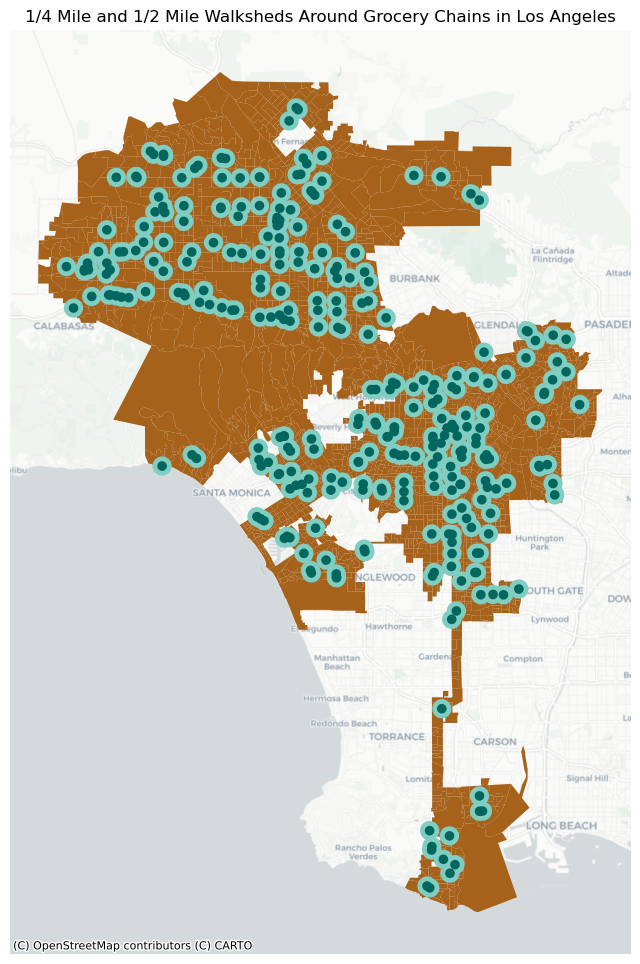

In [26]:
#Plot grocery store locations and walkshed buffers.
fig,ax = plt.subplots(figsize=(12,12))
#ax1=chains_projection.plot(ax=ax, zorder=4, markersize=3, color='yellow')
ax2=chains_buffer_025.plot(ax=ax, zorder=3, color='#01665e')
ax3=chains_buffer_050.plot(ax=ax, zorder=2, color='#80cdc1')
ax4=seniors_projection.plot(ax=ax, zorder=1, color='#a6611a')

ax.axis('off')
ax.set_title('1/4 Mile and 1/2 Mile Walksheds Around Grocery Chains in Los Angeles')
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs='epsg:6423')

plt.savefig('buffers.png')

Now we'll figure out which block groups touch these buffers. Again, this overestimates access, because not all seniors will live within the walkshed of the grocery store.

In [27]:
#Take a closer look at our block group/senior dataset. 
seniors_projection.head()

BG20   ShapeSTArea          FIPS  Total Pop  Age 65-74  Age 75-84  \
0  2742023  1.045276e+06  060372742023        740          0          0   
1  2739025  5.131686e+06  060372739025        763        120         38   
2  2739024  1.861628e+06  060372739024        998         90         10   
3  2739023  1.218168e+06  060372739023       1098         92        137   
4  2735023  4.868382e+06  060372735023        923         29         40   

   Age 85+  Total Senior Pop  Pct Seniors  Square Miles  Pop Density  \
0       13                13     1.756757      0.403581         32.0   
1        0               158    20.707733      1.981346         80.0   
2        0               100    10.020040      0.718775        139.0   
3       11               240    21.857923      0.470335        510.0   
4        0                69     7.475623      1.879684         37.0   

                                            geometry  
0  POLYGON ((1957062.422 552945.617, 1957021.289 ...  
1  MULTIPOLYGON (((1956301.364 553742.388, 195644...  
2  POLYGON ((1956970.245 553315.644, 1956950.061 ...  
3  POLYGON ((1957205.091 554025.253, 1957209.466 ...  
4  POLYGON ((1955951.452 554176.203, 1956105.730 ...

In [28]:
# Make dataset easier to work with by keeping just columns of interest.
seniors_clean=seniors_projection[['BG20','FIPS','Square Miles', 'Total Pop','Total Senior Pop','Pop Density', 'Pct Seniors','geometry']].copy()

seniors_clean.head()

BG20          FIPS  Square Miles  Total Pop  Total Senior Pop  \
0  2742023  060372742023      0.403581        740                13   
1  2739025  060372739025      1.981346        763               158   
2  2739024  060372739024      0.718775        998               100   
3  2739023  060372739023      0.470335       1098               240   
4  2735023  060372735023      1.879684        923                69   

   Pop Density  Pct Seniors                                           geometry  
0         32.0     1.756757  POLYGON ((1957062.422 552945.617, 1957021.289 ...  
1         80.0    20.707733  MULTIPOLYGON (((1956301.364 553742.388, 195644...  
2        139.0    10.020040  POLYGON ((1956970.245 553315.644, 1956950.061 ...  
3        510.0    21.857923  POLYGON ((1957205.091 554025.253, 1957209.466 ...  
4         37.0     7.475623  POLYGON ((1955951.452 554176.203, 1956105.730 ...

Now I will create a copy of this geodataframe that contains each census block group's centroid and treats this point as the geodataframe's primary geography.

In [29]:
# Create a new dataframe to store information about grocery store access to a census block group's centroid.
seniors_centroids=seniors_clean

# Create a centroid column with a geopandas calculation.
seniors_centroids['centroid']=seniors_centroids.centroid

# Make my new centroid column the primary geometry for the geodataframe. 
seniors_centroids=seniors_centroids.set_geometry('centroid')

Now, I will join the two buffer geodataframs to my original census block group dataframe, which will produce information about which census block groups intersect with a grocery store walkshed.<br><br>First I join information about the 0.25 mile buffers to my census block groups.

In [30]:
#Join in the geodataframe of 0.25 mile buffers. 
seniors_buffered=seniors_clean.sjoin(chains_buffer_025, how="left")

#Remove duplicate BG caused by doing a left join.
seniors_buffered = seniors_buffered.drop_duplicates(subset='BG20', keep="first")

#Drop columns that we don't need.
seniors_buffered=seniors_buffered.drop(columns=['index_right','Store_Name', 'Address', 'Address_Line__2', 'City', 'State',
                                                'Zip5', 'Zip4', 'County', 'ObjectId', 'location_type', 'neighborhood_number', 'neighborhood_name'])

#Rename geometry of joined column to be more meaningful.
seniors_buffered.rename(columns = {'geometry_left' : 'geometry', 'geometry_right':'buffer_geo_025',
                                  'chain_name' : 'chain_name_025', 'chain_type' : 'chain_type_025'}, inplace = True)

#Set the blockgroup boundaries to be the geography.
seniors_buffered=seniors_buffered.set_geometry('geometry')

Now I repeat this process with the 0.5 mile buffers.

In [31]:
#Join in the geodataframe of 0.5 mile buffers. 
seniors_buffered2=seniors_buffered.sjoin(chains_buffer_050, how="left")

#Remove duplicate BG caused by doing a left join.
seniors_buffered2 = seniors_buffered2.drop_duplicates(subset='BG20', keep="first")

#Drop columns that we don't need.
seniors_buffered2=seniors_buffered2.drop(columns=['index_right', 'Store_Name', 'Address', 'Address_Line__2', 'City', 'State',
                                                  'Zip5', 'Zip4', 'County', 'ObjectId', 'location_type', 'neighborhood_number', 'neighborhood_name'])

#Rename geometry of joined column to be more meaningful.
seniors_buffered2.rename(columns = {'geometry_left' : 'geometry', 'geometry_right':'buffer_geo_050', 
                                   'chain_name' : 'chain_name_050', 'chain_type' : 'chain_type_050'}, inplace = True)

#Set the blockgroup boundaries to be the geography.
seniors_buffered2=seniors_buffered2.set_geometry('geometry')

We use the information that has been joined in to create a grocery_walkable column that returns a 0 if the census block group does not intersect any grocery store walkshed, a 1 if the block group intersects a 0.5 mile walkshed, and a 2 if the block group intersects a 0.25 mile walkshed.

In [32]:
seniors_buffered2['grocery_walkable']= '1: No walkable grocery store'
seniors_buffered2.loc[seniors_buffered2['buffer_geo_050'].notnull(),
                      'grocery_walkable'] = '2: Grocery store within 1/2 mile'
seniors_buffered2.loc[seniors_buffered2['buffer_geo_025'].notnull(),
                      'grocery_walkable'] = '3: Grocery store within 1/4 mile'

Now we can make a map that colors block groups based on their walking access to grocery stores.

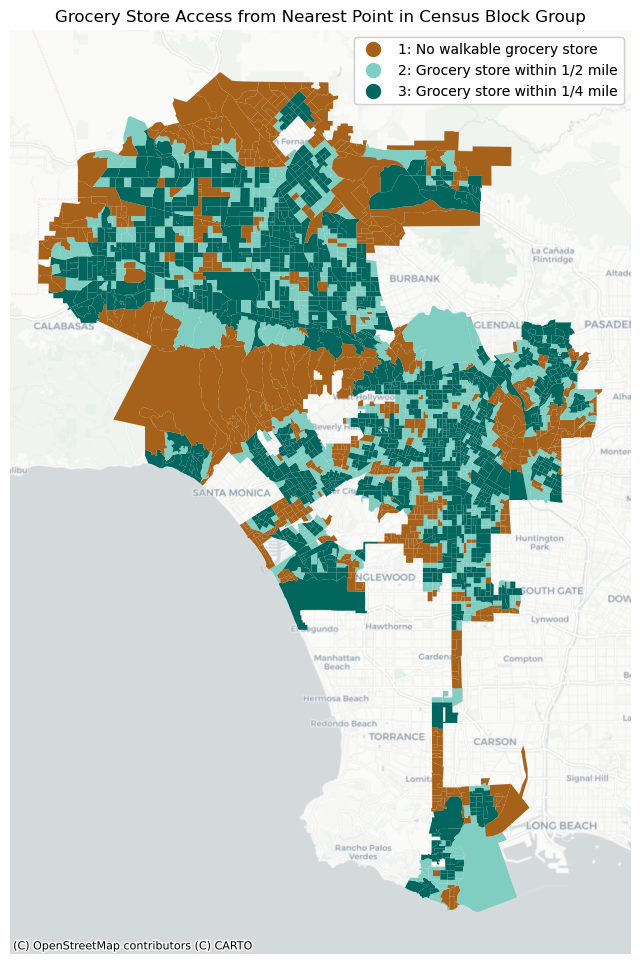

In [33]:
#Plot the block groups that allegedly have access and the grocery store locations.

# Since Python doesn't want me to specific a color and a colomn within the same plot, I'll first create a color column and then a manual legend.
color_dict = {'1: No walkable grocery store': '#a6611a',
 '2: Grocery store within 1/2 mile': '#80cdc1',
 '3: Grocery store within 1/4 mile': '#01665e'}

seniors_buffered2["colors"] = seniors_buffered2["grocery_walkable"].map(color_dict)

fig,ax = plt.subplots(figsize=(12,12))
ax = seniors_buffered2.plot(ax=ax, color = seniors_buffered2["colors"])

# Add manual legend
from matplotlib.lines import Line2D
custom_points = [Line2D([0], [0], marker="o", linestyle="none", markersize=10, color=color) for color in color_dict.values()]
leg_points = ax.legend(custom_points, color_dict.keys())
ax.add_artist(leg_points)

#Format plot.
ax.axis('off')
ax.set_title('Grocery Store Access from Nearest Point in Census Block Group')
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs='epsg:6423')

plt.savefig('intersections.png')

Now, I will repeat all of the steps above but by joining my grocery store walkshed buffers to a geodataframe that uses each census block group's centroid as its primary geometry. This will effectively  only join buffers that contain the centroid (rather than buffers that intersect the entire census block group).<br><br>Like before, I begin by joining the 0.25 mile buffers.

In [34]:
#Join in the geodataframe of 0.25 mile buffers. 
seniors_centroid_buffered=seniors_centroids.sjoin(chains_buffer_025, how="left")

#Remove duplicate BG caused by doing a left join.
seniors_centroid_buffered = seniors_centroid_buffered.drop_duplicates(subset='BG20', keep="first")

#Drop columns that we don't need.
seniors_centroid_buffered=seniors_centroid_buffered.drop(columns=['index_right','Store_Name', 'Address', 'Address_Line__2', 'City', 'State',
                                                'Zip5', 'Zip4', 'County', 'ObjectId', 'location_type', 'neighborhood_number', 'neighborhood_name'])

#Rename geometry of joined column to be more meaningful.
seniors_centroid_buffered.rename(columns = {'geometry_left' : 'geometry', 'geometry_right':'buffer_geo_025',
                                  'chain_name' : 'chain_name_025', 'chain_type' : 'chain_type_025'}, inplace = True)

#Set the blockgroup boundaries to be the geography.
seniors_centroid_buffered=seniors_centroid_buffered.set_geometry('centroid')

Next I join in the 0.5 mile buffers.

In [35]:
#Join in the geodataframe of 0.5 mile buffers. 
seniors_centroid_buffered2=seniors_centroid_buffered.sjoin(chains_buffer_050, how="left")

#Remove duplicate BG caused by doing a left join.
seniors_centroid_buffered2 = seniors_centroid_buffered2.drop_duplicates(subset='BG20', keep="first")

#Drop columns that we don't need.
seniors_centroid_buffered2=seniors_centroid_buffered2.drop(columns=['index_right', 'Store_Name', 'Address', 'Address_Line__2', 'City', 'State',
                                                  'Zip5', 'Zip4', 'County', 'ObjectId', 'location_type', 'neighborhood_number', 'neighborhood_name'])

#Rename geometry of joined column to be more meaningful.
seniors_centroid_buffered2.rename(columns = {'geometry_left' : 'geometry', 'geometry_right':'buffer_geo_050', 
                                   'chain_name' : 'chain_name_050', 'chain_type' : 'chain_type_050'}, inplace = True)

#Set the blockgroup boundaries to be the geography.
seniors_centroid_buffered2=seniors_centroid_buffered2.set_geometry('geometry')

Finally I use the columns that have been joined to categorie each census block group as having a centroid that is either 1) Outside of all grocery store buffers, 2) Within a 0.5 mile buffer but not the 0.25 mile buffer of a grocery store, or 3) Within a 0.25 mile buffer of a grocery store.

In [36]:
seniors_centroid_buffered2['grocery_walkable']= '1: No walkable grocery store'
seniors_centroid_buffered2.loc[seniors_centroid_buffered2['buffer_geo_050'].notnull(),
                               'grocery_walkable'] = '2: Grocery store within 1/2 mile'
seniors_centroid_buffered2.loc[seniors_centroid_buffered2['buffer_geo_025'].notnull(), 
                               'grocery_walkable'] = '3: Grocery store within 1/4 mile'

Finally, I map my census tracts, categorized by their walk access to grocery stores.

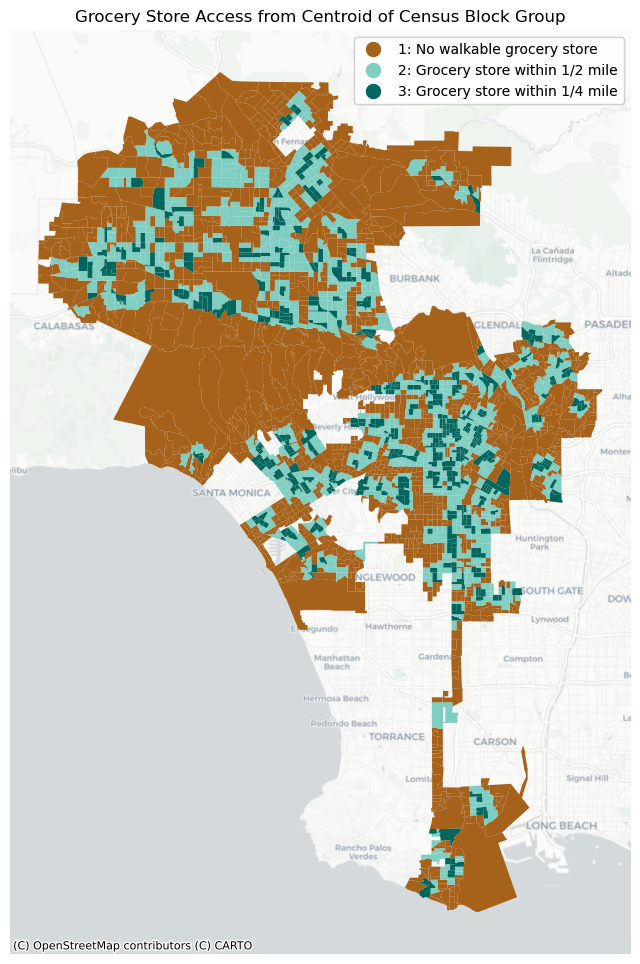

In [45]:
#Plot the block groups that allegedly have access and the grocery store locations.

# Since Python doesn't want me to specific a color and a colomn within the same plot, I'll first create a color column and then a manual legend.
color_dict = {'1: No walkable grocery store': '#a6611a',
 '2: Grocery store within 1/2 mile': '#80cdc1',
 '3: Grocery store within 1/4 mile': '#01665e'}

seniors_centroid_buffered2["colors"] = seniors_centroid_buffered2["grocery_walkable"].map(color_dict)


fig,ax = plt.subplots(figsize=(12,12))
ax = seniors_centroid_buffered2.plot(ax=ax, color = seniors_centroid_buffered2["colors"])

# Add manual legend
from matplotlib.lines import Line2D
custom_points = [Line2D([0], [0], marker="o", linestyle="none", markersize=10, color=color) for color in color_dict.values()]
leg_points = ax.legend(custom_points, color_dict.keys())
ax.add_artist(leg_points)

#Format plot.
ax.axis('off')
ax.set_title('Grocery Store Access from Centroid of Census Block Group')
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs='epsg:6423')

plt.savefig('centroids.png')

### Part 3: Relating Walkable Areas to Senior Population
Finally, we can use this information to do some basic calculations about how likely Seniors are to live within walking distance, and whether they have worse (or better) acess than the general population of Los Angeles.

First, I want to create a new table that contains calculations about what percentage of Seniors and All Residents live within walking distance of a grocery store.

In [38]:
# Sum up all of the data for all of the block groups in each category.
senior_sums = seniors_centroid_buffered2.groupby(by='grocery_walkable').sum()

# Keep just the columns that we're interested in.
senior_sums=senior_sums[['Square Miles','Total Pop','Total Senior Pop']]

# Create calculated columns. 
senior_sums['Pct of All Population']=senior_sums['Total Pop']/(senior_sums['Total Pop'].sum())
senior_sums['Pct of Seniors']=senior_sums['Total Senior Pop']/(senior_sums['Total Senior Pop'].sum())
senior_sums

/tmp/ipykernel_1322/2650673610.py:2: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



Square Miles  Total Pop  Total Senior Pop  \
grocery_walkable                                                              
1: No walkable grocery store       6770.542590    2017988            287881   
2: Grocery store within 1/2 mile   1269.783316    1528839            186973   
3: Grocery store within 1/4 mile    513.095960     746372             86685   

                                  Pct of All Population  Pct of Seniors  
grocery_walkable                                                         
1: No walkable grocery store                   0.470043        0.512664  
2: Grocery store within 1/2 mile               0.356107        0.332965  
3: Grocery store within 1/4 mile               0.173850        0.154370

To be able to turn this into a bar graph, I'll have to reformat my table so that all of the percentages ("Pct of ALl Population" & "Pct of Seniors") have their own row which is marked by what type of percentage it is.

First, I reset the index so that grocery_walkable is a usable column.

In [39]:
# Reset index.
senior_sums=senior_sums.reset_index(names='grocery_walkable')

Now I'll create rows for just Seniors to insert into my final table.

In [40]:
# Create new table with just level of walk access and percentage of seniors living in that type of area. 
senior_sums_seniors=senior_sums[['grocery_walkable','Pct of Seniors']].copy()

# Rename columns so that this will merge with table of All Residents. 
senior_sums_seniors.rename(columns = {'grocery_walkable' : 'Walking Access', 'Pct of Seniors':'Percent'}, inplace = True)

# Create a new column that will preserve the information that this data relates to Seniors. 
senior_sums_seniors['Population'] = 'Seniors'

# Take a look at 3 rows that were produced.
senior_sums_seniors

Walking Access   Percent Population
0      1: No walkable grocery store  0.512664    Seniors
1  2: Grocery store within 1/2 mile  0.332965    Seniors
2  3: Grocery store within 1/4 mile  0.154370    Seniors

Now I'll create rows for just All Residents to insert into my final table.

In [41]:
# Create new table with just level of walk access and percentage of all residents living in that type of area. 
senior_sums_all=senior_sums[['grocery_walkable','Pct of All Population']].copy()

# Rename columns so that this will merge with table of Seniors. 
senior_sums_all.rename(columns = {'grocery_walkable' : 'Walking Access', 'Pct of All Population':'Percent'}, inplace = True)

# Create a new column that will preserve the information that this data relates to All Residents. 
senior_sums_all['Population'] = 'All Residents'

# Take a look at 3 rows that were produced.
senior_sums_all

Walking Access   Percent     Population
0      1: No walkable grocery store  0.470043  All Residents
1  2: Grocery store within 1/2 mile  0.356107  All Residents
2  3: Grocery store within 1/4 mile  0.173850  All Residents

Now, we create a table with both of these sets of rows merged together.

In [42]:
senior_sums_plot=pd.concat([senior_sums_seniors,senior_sums_all],ignore_index = True)

# Take a look at the table that was produced.
senior_sums_plot

Walking Access   Percent     Population
0      1: No walkable grocery store  0.512664        Seniors
1  2: Grocery store within 1/2 mile  0.332965        Seniors
2  3: Grocery store within 1/4 mile  0.154370        Seniors
3      1: No walkable grocery store  0.470043  All Residents
4  2: Grocery store within 1/2 mile  0.356107  All Residents
5  3: Grocery store within 1/4 mile  0.173850  All Residents

I want my labels to be in percentages rather than decimal data, so I transform the percentage column.

In [43]:
# Multiply each value by 100 and then round it to the nearest integer.
senior_sums_plot['Percent']=round(senior_sums_plot['Percent']*100)

I can now create my plot!

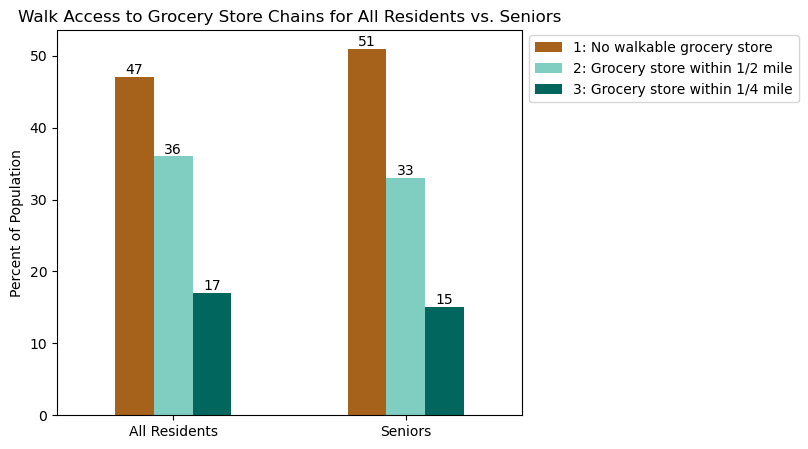

In [44]:
# Import numpy.
import numpy as np

# First I create a pivot table.
access_pivot = pd.pivot_table(senior_sums_plot, 
                          values="Percent", 
                          index="Population", 
                          columns="Walking Access", 
                          aggfunc=np.mean)

# Now I plot the pivot table.
fig, ax = plt.subplots(figsize=(6,5))

ax = access_pivot.plot(ax=ax, kind='bar',color=['#a6611a', '#80cdc1', '#01665e'] ,legend=True)
ax.bar_label(ax.containers[0], label_type='edge')
ax.bar_label(ax.containers[1], label_type='edge')
ax.bar_label(ax.containers[2], label_type='edge')

# Adjust x-axis.
plt.xlabel(None)
plt.xticks(rotation=0)

# Ajust y-axis.
plt.ylabel("Percent of Population")

#Adjust table and legend.
plt.title("Walk Access to Grocery Store Chains for All Residents vs. Seniors")
plt.legend(loc='center left', bbox_to_anchor=(1, .9))

plt.savefig('senior_access.png',bbox_inches="tight")

plt.show()